# Phân Loại TDE MALLORN - Dự Đoán và Tạo Submission

**Mục tiêu:** Generate predictions và tạo file submission cho Kaggle.

**QUAN TRỌNG:** 
- File submission phải có **ĐÚNG 7135 rows** (tương ứng với số test objects)
- Format: 2 cột `object_id` và `prediction` (0 hoặc 1)
- Sử dụng optimal threshold đã tìm được từ training để maximize F1 score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
DATA_DIR = Path('../mallorn-astronomical-classification-challenge')

## 1. Load Model và Dữ Liệu

Load mô hình đã train, scaler, và model_info chứa optimal threshold.

In [2]:
lgb_model = joblib.load('lgb_model.joblib')
scaler = joblib.load('scaler.joblib')
model_info = joblib.load('model_info.joblib')

best_threshold = model_info['best_threshold']
feature_cols = model_info['feature_cols']

print("Model loaded successfully!")
print(f"  Optimal threshold: {best_threshold:.3f}")
print(f"  CV F1 Score: {model_info['best_f1']:.4f}")
print(f"  CV Precision: {model_info['best_precision']:.4f}")
print(f"  CV Recall: {model_info['best_recall']:.4f}")
print(f"  Number of features: {len(feature_cols)}")

Model loaded successfully!
  Optimal threshold: 0.330
  CV F1 Score: 0.5735
  CV Precision: 0.6290
  CV Recall: 0.5270
  Number of features: 294


In [3]:
test_features = pd.read_csv('test_features.csv')
test_log = pd.read_csv(DATA_DIR / 'test_log.csv')

print(f"\nTest features loaded: {len(test_features)} objects")
print(f"Test log entries: {len(test_log)} objects")
print(f"\nExpected submission rows: {len(test_log)}")


Test features loaded: 7135 objects
Test log entries: 7135 objects

Expected submission rows: 7135


## 2. Verify Tính Đầy Đủ Của Dữ Liệu

Kiểm tra xem tất cả test objects đều có features hay không.

In [4]:
test_log_ids = set(test_log['object_id'])
test_feature_ids = set(test_features['object_id'])

missing_ids = test_log_ids - test_feature_ids

print(f"Objects in test_log: {len(test_log_ids)}")
print(f"Objects with features: {len(test_feature_ids)}")
print(f"Missing objects: {len(missing_ids)}")

if len(missing_ids) > 0:
    print(f"\nWARNING: {len(missing_ids)} objects are missing features!")
    print(f"First 5 missing: {list(missing_ids)[:5]}")
else:
    print("\n✓ All test objects have features extracted!")

Objects in test_log: 7135
Objects with features: 7135
Missing objects: 0

✓ All test objects have features extracted!


## 3. Chuẩn Bị Test Data

Đảm bảo test data có đúng features và scale bằng scaler đã fit trên train.

In [5]:
for col in feature_cols:
    if col not in test_features.columns:
        test_features[col] = 0
        print(f"Added missing column: {col}")

X_test = test_features[feature_cols].values
X_test_scaled = scaler.transform(X_test)

print(f"\nTest matrix shape: {X_test_scaled.shape}")


Test matrix shape: (7135, 294)


## 4. Generate Predictions

Dự đoán xác suất TDE cho mỗi test object và convert sang binary predictions với optimal threshold.

In [6]:
print("="*60)
print("Generating predictions...")
print("="*60)

test_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]
test_preds = (test_proba >= best_threshold).astype(int)

print(f"\nPredictions complete!")
print(f"  Total predictions: {len(test_preds)}")
print(f"  Predicted TDEs: {test_preds.sum()} ({100*test_preds.mean():.2f}%)")
print(f"  Predicted Non-TDEs: {len(test_preds) - test_preds.sum()} ({100*(1-test_preds.mean()):.2f}%)")

Generating predictions...

Predictions complete!
  Total predictions: 7135
  Predicted TDEs: 296 (4.15%)
  Predicted Non-TDEs: 6839 (95.85%)


## 5. Phân Tích Phân Bố Predictions

Kiểm tra phân bố xác suất và predictions để đảm bảo hợp lý.

In [7]:
print("\n=== Probability Statistics ===")
print(f"Mean probability: {test_proba.mean():.4f}")
print(f"Median probability: {np.median(test_proba):.4f}")
print(f"Std probability: {test_proba.std():.4f}")
print(f"Min probability: {test_proba.min():.4f}")
print(f"Max probability: {test_proba.max():.4f}")

print(f"\nPercentiles:")
for p in [5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th percentile: {np.percentile(test_proba, p):.4f}")


=== Probability Statistics ===
Mean probability: 0.0379
Median probability: 0.0003
Std probability: 0.1444
Min probability: 0.0000
Max probability: 0.9977

Percentiles:
  5th percentile: 0.0000
  10th percentile: 0.0001
  25th percentile: 0.0001
  50th percentile: 0.0003
  75th percentile: 0.0027
  90th percentile: 0.0424
  95th percentile: 0.2413
  99th percentile: 0.8980


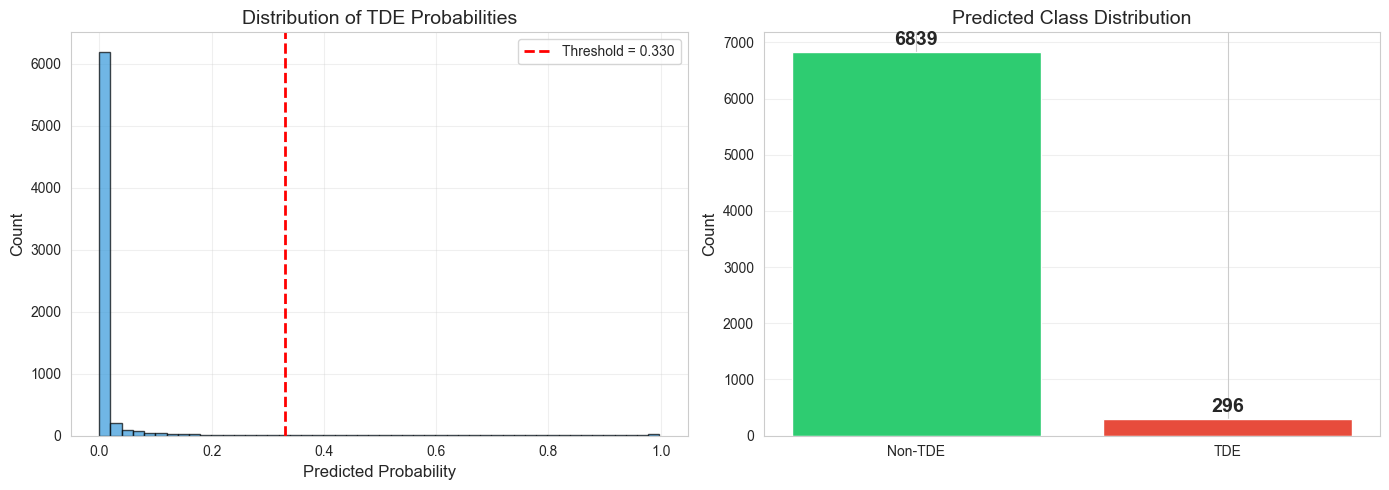

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(test_proba, bins=50, alpha=0.7, color='#3498db', edgecolor='black')
axes[0].axvline(best_threshold, color='red', linestyle='--', linewidth=2, 
                label=f'Threshold = {best_threshold:.3f}')
axes[0].set_xlabel('Predicted Probability', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of TDE Probabilities', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

pred_counts = [len(test_preds) - test_preds.sum(), test_preds.sum()]
bars = axes[1].bar(['Non-TDE', 'TDE'], pred_counts, color=['#2ecc71', '#e74c3c'])
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Class Distribution', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

for bar, count in zip(bars, pred_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 str(count), ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('prediction_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. TDE Candidates Có Độ Tin Cậy Cao

Liệt kê các objects được dự đoán là TDE với xác suất cao nhất.

In [9]:
test_results = test_features[['object_id']].copy()
test_results['probability'] = test_proba
test_results['prediction'] = test_preds

high_conf_threshold = 0.9
high_conf_tdes = test_results[test_results['probability'] >= high_conf_threshold]

print(f"High confidence TDEs (prob >= {high_conf_threshold}): {len(high_conf_tdes)}")

if len(high_conf_tdes) > 0:
    print(f"\nTop 15 highest probability TDEs:")
    top_tdes = test_results.nlargest(15, 'probability')
    for _, row in top_tdes.iterrows():
        print(f"  {row['object_id']}: {row['probability']:.4f}")

High confidence TDEs (prob >= 0.9): 71

Top 15 highest probability TDEs:
  aegas_nell_amon: 0.9977
  alae_maecheneb_nath: 0.9963
  loss_iaun_cund: 0.9954
  galas_agor_nimbrethil: 0.9939
  eirien_gaur_maen: 0.9924
  hand_dunedhel_honeg: 0.9920
  romru_cund_gwathui: 0.9920
  bregedur_lebdas_iphant: 0.9911
  myril_duin_badhor: 0.9903
  emel_mithril_rusc: 0.9868
  cabed_galas_aear: 0.9863
  adab_rusc_heleg: 0.9860
  imrad_fae_amlug: 0.9860
  sador_luin_iphant: 0.9852
  sirion_dam_luith: 0.9847


## 7. Tạo File Submission

Tạo submission DataFrame với format chuẩn Kaggle: object_id, prediction

In [10]:
submission = pd.DataFrame({
    'object_id': test_features['object_id'],
    'prediction': test_preds
})

submission_full = test_log[['object_id']].merge(
    submission,
    on='object_id',
    how='left'
)

if submission_full['prediction'].isnull().sum() > 0:
    print(f"WARNING: {submission_full['prediction'].isnull().sum()} missing predictions!")
    submission_full['prediction'] = submission_full['prediction'].fillna(0).astype(int)

submission_full['prediction'] = submission_full['prediction'].astype(int)

print(f"\nSubmission dataframe created!")
print(f"  Rows: {len(submission_full)}")
print(f"  Expected: {len(test_log)}")
print(f"  Match: {'✓' if len(submission_full) == len(test_log) else '✗ MISMATCH!'}")


Submission dataframe created!
  Rows: 7135
  Expected: 7135
  Match: ✓


In [11]:
submission_full.to_csv('submission.csv', index=False)

verify = pd.read_csv('submission.csv')

print("\n" + "="*60)
print("SUBMISSION FILE CREATED")
print("="*60)
print(f"\nFile: submission.csv")
print(f"Total rows: {len(verify)}")
print(f"Expected rows: 7135")
print(f"Match: {'✓ CORRECT' if len(verify) == 7135 else '✗ INCORRECT!'}")
print(f"\nPrediction breakdown:")
print(f"  TDEs (1): {verify['prediction'].sum()}")
print(f"  Non-TDEs (0): {len(verify) - verify['prediction'].sum()}")
print(f"\nColumns: {verify.columns.tolist()}")
print(f"Unique predictions: {sorted(verify['prediction'].unique())}")


SUBMISSION FILE CREATED

File: submission.csv
Total rows: 7135
Expected rows: 7135
Match: ✓ CORRECT

Prediction breakdown:
  TDEs (1): 296
  Non-TDEs (0): 6839

Columns: ['object_id', 'prediction']
Unique predictions: [np.int64(0), np.int64(1)]


## 8. Verify Format Submission

Kiểm tra kỹ format và số lượng rows trước khi submit lên Kaggle.

In [12]:
print("\nSubmission file preview (first 10 rows):")
print(verify.head(10).to_string(index=False))

print(f"\n... (showing first and last 5 rows)")
print("\nLast 5 rows:")
print(verify.tail(5).to_string(index=False))


Submission file preview (first 10 rows):
                   object_id  prediction
    Eluwaith_Mithrim_nothrim           0
          Eru_heledir_archam           0
           Gonhir_anann_fuin           0
Gwathuirim_haradrim_tegilbor           0
            achas_minai_maen           0
               adab_fae_gath           0
             adel_draug_gaur           0
     aderthad_cuil_galadhrim           0
         aegas_laug_ithildin           0
            aegas_mereth_law           0

... (showing first and last 5 rows)

Last 5 rows:
        object_id  prediction
  ungol_ulug_saew           0
uruk_Ennor_tirith           0
    ylf_faen_lost           0
 yll_firiel_ruith           0
yll_randir_bragol           0


In [13]:
print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"\nModel Performance (CV):")
print(f"  F1 Score: {model_info['best_f1']:.4f}")
print(f"  Precision: {model_info['best_precision']:.4f}")
print(f"  Recall: {model_info['best_recall']:.4f}")
print(f"  ROC-AUC: {model_info['roc_auc']:.4f}")
print(f"  Threshold: {best_threshold:.3f}")

print(f"\nSubmission:")
print(f"  File: submission.csv")
print(f"  Rows: {len(verify)}")
print(f"  Predicted TDEs: {verify['prediction'].sum()}")

print(f"\n✓ Ready to submit to Kaggle!")
print(f"  https://www.kaggle.com/competitions/mallorn-astronomical-classification-challenge")
print("="*60)


FINAL SUMMARY

Model Performance (CV):
  F1 Score: 0.5735
  Precision: 0.6290
  Recall: 0.5270
  ROC-AUC: 0.9421
  Threshold: 0.330

Submission:
  File: submission.csv
  Rows: 7135
  Predicted TDEs: 296

✓ Ready to submit to Kaggle!
  https://www.kaggle.com/competitions/mallorn-astronomical-classification-challenge
